In [ ]:
# created by GO 20230613

# purpose: get confidence around trends in temp at Nanoose

# data in: bimonthly anomalies, model and observations for salt and temp
#          as NetCDF (data from Visuals-Data - CTD Obs, Mod at Nanoose (Blind))

# last modified: 20230921
# done: streamline flow and update to run216 (change names out in previous notebook)
# 20230921 - the depth integrated averaging is fixed
#          - tested mann kendall instead of simple bootstrapping

In [272]:
import os
import xarray as xr

import cartopy as cp
import matplotlib.pyplot as plt
import numpy as np
import glob

import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle
import cmocean as cm

import time
import datetime as dt

from scipy import interpolate
from scipy.stats import kendalltau
import pymannkendall as mk

In [291]:
def mann_kendall_trend(data, alpha=0.05):
    # You may need to preprocess the data here if it's not in the right format
    # For example, convert it to a pandas Series if it's not already
    #data_series = pd.Series(data)
    
    # Apply the Mann-Kendall test
    result = mk.original_test(data, alpha=alpha)
    
    return result.slope, result.h, result.intercept
    
def mann_kendall_seasonal(data, period=3, alpha=0.05):
    # You may need to preprocess the data here if it's not in the right format
    # For example, convert it to a pandas Series if it's not already
    #data_series = pd.Series(data)
    
    # Apply the Mann-Kendall test
    result = mk.seasonal_test(data, period=period, alpha=alpha)
    
    return result.slope, result.h, result.intercept


# Function to compute the slope of the linear trend
def compute_slope(x, y):
    regression = LinearRegression()
    regression.fit(x, y)
    return regression.coef_[0]

def compute_slope_GO(x,y):
    m, c = np.linalg.lstsq(x, y, rcond=None)[0]
    return m, c

def get_bootstrapped_CI(n_iter, ts, ts_time):
    
    # method = 'lr' (lin regression) or 'mk' mann kendall
    
#     values = ts.values[~np.isnan(ts.values)]
    values = ts[~np.isnan(ts)]
    #time = ts_time[~np.isnan(ts.values)]
    time = ts_time[~np.isnan(ts)]
    # Fit linear regression to the original data
    # regression = LinearRegression()
    # regression.fit(time.reshape(-1, 1), values)
    
    A = np.vstack([time, np.ones(len(time))]).T
    orig_slope, orig_bias = compute_slope_GO(A,values)
    
    mann_kendall_trend

    # Initialize an array to store the slopes
    bootstrap_slopes = np.zeros(n_iter)
    bootstrap_biases = np.zeros(n_iter)

    # Perform bootstrapping
    for i in range(n_iter):

        # Generate a bootstrap sample by resampling with replacement
        indices = np.random.choice(len(values), len(values), replace=True)
        bootstrap_sample = values[indices]
        bootstrap_time = time[indices]
        A = np.vstack([bootstrap_time, np.ones(len(bootstrap_time))]).T

        # Compute the slope of the linear trend on the bootstrap sample
    #     bootstrap_slope = compute_slope_GO(bootstrap_time.reshape(-1, 1), bootstrap_sample)
        bootstrap_slope, bootstrap_b = compute_slope_GO(A, bootstrap_sample)
        bootstrap_slopes[i] = bootstrap_slope
        bootstrap_biases[i] = bootstrap_b
        
    return bootstrap_slopes, bootstrap_biases, orig_slope, orig_bias

def plot_trend_lr(ax, tyr, tempdata, n_iterations, 
               bs_slopes, bs_biases, orig_slope, 
               orig_bias, lbl,
               max_y=1,
               min_y=-1
              ):
    
#     ax.plot(tyr,tempdata.values,linewidth = 0.5, alpha = 0.5)
    ax.plot(tyr,tempdata,linewidth = 0.5, alpha = 0.5)

#     x = tyr[~np.isnan(tempdata.values)]
#     y = tempdata.values[~np.isnan(tempdata.values)]
    
    x = tyr[~np.isnan(tempdata)]
    y = tempdata[~np.isnan(tempdata)]
    
    # A = np.vstack([x, np.ones(len(x))]).T
    # m, c = np.linalg.lstsq(A, y, rcond=None)[0] # old way
    ax.plot(x, y, '.', label=lbl, markersize=2)
    
    # Plot the linear regression lines from the bootstrap samples
    for i in range(n_iterations):
        if i == 0:
            ax.plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=1, label="95% CI")
        else:
            ax.plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=0.02)

    ax.plot(x, orig_slope*x + orig_bias, 'r', label=f'{round(orig_slope*10,3)} $^\circ$C / decade')
    
    ax.set_ylim(min_y, max_y)  
    
    # reorder legend
    plt.sca(ax)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,2,1]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
    ax.axhline(y=0)
    ax.grid()
    
def plot_trend_mk(ax, 
                  dat, tyr_idx, tyr,
                  slope, bias,  
                  lbl, 
                  max_y=1,min_y=-1):
    
    ax.plot(tyr,dat,linewidth = 0.5, alpha = 0.5)
    
    x = tyr_idx[~np.isnan(dat)]
    tyr = tyr[~np.isnan(dat)]
    y = dat[~np.isnan(dat)]
    
    ax.plot(tyr, y, '.', label=lbl, markersize=2)
    ax.plot(tyr, slope*x + bias, 'r', label=f'{round(slope*10*24,3)} $^\circ$C / decade')

    ax.set_ylim(min_y, max_y)  
    
    # reorder legend
    plt.sca(ax)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,1]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
              loc = 'upper center',
              ncol = 2,
              fontsize=8)
    ax.axhline(y=0)
    ax.grid()


######## Model  SalishSea1500-RUN203  #########
=========== Mann Kendall Method ===========
        (Seasonal w/ period 24)        
obs slope:  0.0035457588316284193
significant at p<= 0.05 :  True
------------------------------------
mod slope:  0.0027336568105940456
significant at p<= 0.05 :  True
------------------------------------
        (Non seasonal)        
obs slope:  0.003614671120039773
significant at p<= 0.05 :  True
------------------------------------
mod slope:  0.002730972662561112
significant at p<= 0.05 :  True
------------------------------------
=========== Bootstrapping method ===========
Original slope: 0.0038
95% Confidence Interval: 0.0018 to 0.0057
Is the trend significant at the 95% level? Yes
-----------------------------------------------
Original slope (annual): 0.0036
95% Confidence Interval: 0.0017 to 0.0055
Is the trend significant at the 95% level? Yes

######## Model  SalishSea1500-RUN216  #########
=========== Mann Kendall Method ===========
       

Text(0.01, 0.97, '(c)')

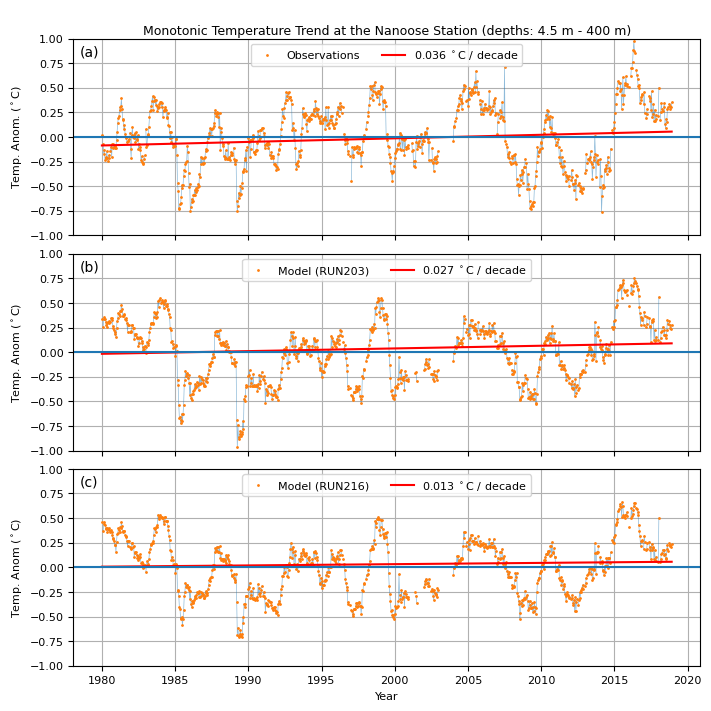

In [292]:
var = 'temp' # 'temp' or 'salt'
plot_which = 'mk' # 'mk' (mann kendall) or 'lr' (linear regression)


modelruns_info = {'SalishSea1500-RUN203': {'path': './climatol_intermediate_files/',
                                           'shortcode': 'RUN203'},
                  'SalishSea1500-RUN216': {'path': './climatol_intermediate_files/',
                                           'shortcode': 'RUN216'}
                 }

# depth range in metres
# this is determined in previous notebook - the depths are truncated to match Masson
# so this must match or shapes of e3t0 etc won't match
depth_min = 4.5
depth_max = 400


###########################################
# params for bootstrapping
## compute the confidence intervals for the regressions #
# Number of bootstrap iterations
n_iterations = 1000
tyr = np.arange(1980,2019,(1/24))
###########################################

alpha = 0.05


import netCDF4 as nc
meshm_p = '../data/mesh mask/'
meshm_f = 'mesh_mask_20210406.nc'

with nc.Dataset(os.path.join(meshm_p, meshm_f)) as mesh:
#     print(mesh.variables)
    tmask=mesh.variables['tmask'][:] # 0's where depth lev exceeds
#     umask=mesh.variables['umask'][:]
#     vmask=mesh.variables['vmask'][:]
#     fmask=mesh.variables['fmask'][:]
    e3t0=mesh.variables['e3t_0'][:] # 'widths' or 'weights' for each depth lev
#     e3u0=mesh.variables['e3u_0'][:]
#     e3v0=mesh.variables['e3v_0'][:]
#     e3w0=mesh.variables['e3w_0'][:]
    gdept_0=mesh.variables['gdept_0'][:]

# depths, tmask, and e3t0 at nanoose:
gdept_0 = gdept_0[0,:,175, 75]
e3t0 = e3t0[0,:,175, 75]
tmask = tmask[0,:,175, 75]

# find closest idx in deptht to the min / max depths
diffs_min = np.abs(gdept_0 - depth_min)
min_idx = np.argmin(diffs_min)
diffs_max = np.abs(gdept_0 - depth_max)
max_idx = np.argmin(diffs_max)
# # create mask for the depth range
# dg_mask = np.zeros(gdept_0.shape, dtype=int)        
# dg_mask[min_idx:max_idx+1] = 1
# # truncate the e3t0 vector
# # e3t0_2 = e3t0 * tmask * dg_mask

e3t0_2 = e3t0[min_idx:max_idx+1]
gdept_0 = gdept_0[min_idx:max_idx+1]


# plot size scalar
fact = 1.4

###################################################
#plots
fig, axs = plt.subplots(3,1, figsize=(5*fact, 5*fact), facecolor='w', edgecolor='k', constrained_layout=True)
axs = axs.ravel()

m = 0
for model in modelruns_info.keys():
    
    ################################################
    # data 
    print('')
    print('######## Model ', model, ' #########')
    mod_run = modelruns_info[model]['shortcode']
    path1 = modelruns_info[model]['path']
     
    obs_anom_f = mod_run + 'obs_anom_' + var + '_1980-2018.nc'
    mod_anom_f = mod_run + 'mod_anom_' + var + '_1980-2018.nc'
    obs_anom = xr.open_dataset(os.path.join(path1,obs_anom_f))
    mod_anom= xr.open_dataset(os.path.join(path1,mod_anom_f))

    obs = obs_anom.isel(deptht = obs_anom.deptht >= depth_min)
    mod = mod_anom.isel(deptht = mod_anom.deptht >= depth_min)
    obs = obs.isel(deptht = obs.deptht <= depth_max)
    mod = mod.isel(deptht = mod.deptht <= depth_max)
    
    if var == 'temp':
        obs = obs['temperature']
        mod = mod['temperature']
    else:
        obs = obs['salinity']
        mod = mod['salinity']
        
    ##################################################
    # calculate depth integrated mean 
    
    # replace values in e3t where obs are nans with nans
    nan_indices = np.isnan(obs)
    # add dimensions to e3t to match shape of data
    obs_shape = obs.shape # should be 34, 936
    e3t0_3 = e3t0_2[:, np.newaxis]
    e3t0_3 = np.repeat(e3t0_3, obs_shape[1], axis=1) 
    e3t0_3[nan_indices] = np.nan
    
    # calculate weighted average using e3t_0
    sum_e3t = np.nansum(e3t0_3, axis=0)
    e3t0_weights = np.where(sum_e3t != 0, e3t0_3 / sum_e3t[np.newaxis, :], 0)
#     crosscheck_weights = np.nansum(e3t0_weights, axis=0)
#     print(crosscheck_weights) # should sum to one or be zeros (zeros replaced with nan later)
    weighted_vals = obs * e3t0_weights
    obs_avg = np.sum(weighted_vals, axis=0) # sum instead of nansum keeps it as xarray dataarray
    obs_avg = obs_avg.where(obs_avg != 0, np.nan)
    weighted_vals = mod * e3t0_weights
    mod_avg = np.sum(weighted_vals, axis=0) 
    mod_avg = mod_avg.where(mod_avg != 0, np.nan)
    ##################################################
    
    ###################################################
    print('=========== Mann Kendall Method ===========')
    # Mann Kendall trend
    period = 24 
    # there is no annual or seasonal period on anomalies based on annual clima
    # so not sure why the trend estimate is so neutral without it. 
#     slope, h = mann_kendall_trend(obs_avg)
    print('        (Seasonal w/ period 24)        ')
    slope_obs_seas_mk, h, intercept_obs_seas_mk = mann_kendall_seasonal(obs_avg, period, alpha)
    print('obs slope: ', slope_obs_seas_mk)
    print('significant at p<=', alpha, ': ', h)
    print('------------------------------------')
#     slope, h = mann_kendall_trend(mod_avg)
    slope_mod_seas_mk, h, intercept_mod_seas_mk = mann_kendall_seasonal(mod_avg, period, alpha)
    print('mod slope: ', slope_mod_seas_mk)
    print('significant at p<=', alpha, ': ', h)
    print('------------------------------------')
    
    print('        (Non seasonal)        ')
    slope_obs_mk, h, intercept_obs_mk = mann_kendall_trend(obs_avg, alpha)
    slope_obs_mk = slope_obs_mk * 24 # recall biweekly so this is required
    print('obs slope: ', slope_obs_mk)
    print('significant at p<=', alpha, ': ', h)
    print('------------------------------------')
#     slope, h = mann_kendall_trend(mod_avg)
    slope_mod_mk, h, intercept_mod_mk = mann_kendall_trend(mod_avg, alpha)
    slope_mod_mk = slope_mod_mk * 24
    print('mod slope: ', slope_mod_mk)
    print('significant at p<=', alpha, ': ', h)
    print('------------------------------------')
    ###################################################
    
    
    ###################################################
    print('=========== Bootstrapping method ===========')
    #bootstrap analysis - obser
    bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, obs_avg.values, tyr)
    confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
    # Check if the original slope is within the confidence interval
    is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
    # Print the results
    print(f"Original slope: {orig_slope:.4f}")
    print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
    print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")
    print('-----------------------------------------------')
    
    
    #bootstrap analysis - model
    bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, mod_avg, tyr)
    confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
    # Check if the original slope is within the confidence interval
    is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
    # Print the results
    print(f"Original slope (annual): {orig_slope:.4f}")
    print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
    print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")
    ###################################################
   

    ###################################################
    # plots
    
    if plot_which == 'mk':
        if m == 0:
            lbl = "Observations"
            plot_trend_mk(axs[0],
                          obs_avg, np.arange(len(obs_avg['time_counter'])), tyr,
                          slope_obs_mk/24, 
                          intercept_obs_mk,  
                          lbl
                         )

            lbl = "Model (" + mod_run + ")"
            plot_trend_mk(axs[1],
                          mod_avg, np.arange(len(mod_avg['time_counter'])), tyr,
                          slope_mod_mk/24, 
                          intercept_mod_mk,  
                          lbl
                         )

        else:
            lbl = "Model (" + mod_run + ")"
            plot_trend_mk(axs[2],
                          mod_avg, np.arange(len(mod_avg['time_counter'])), tyr,
                          slope_mod_mk/24, 
                          intercept_mod_mk,  
                          lbl
                         ) 
            
    elif plot_which == 'lr':
        if m == 0:
            lbl = "Observations"
            plot_trend_lr(axs[0], 
                       tyr, 
                       obs_avg, 
                       n_iterations, 
                       bs_slopes, 
                       bs_biases, 
                       orig_slope, 
                       orig_bias, 
                       lbl)

            lbl = "Model (" + mod_run + ")"
            plot_trend_lr(axs[1], 
                       tyr, 
                       mod_avg, 
                       n_iterations, 
                       bs_slopes, 
                       bs_biases, 
                       orig_slope, 
                       orig_bias, 
                       lbl)

        else:
            lbl = "Model (" + mod_run + ")"
            plot_trend_lr(axs[2], 
                       tyr, 
                       mod_avg, 
                       n_iterations, 
                       bs_slopes, 
                       bs_biases, 
                       orig_slope, 
                       orig_bias, 
                       lbl)
    
    # reorder legend
#     plt.sca(axs[1])
#     handles, labels = plt.gca().get_legend_handles_labels()
#     order = [0,2,1]
#     axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
#     axs[1].axhline(y=0)
#     axs[1].grid()
    ###################################################

    m+=1

axs[0].set_title('\nMonotonic Temperature Trend at the Nanoose Station (depths: ' + str(depth_min) + ' m - ' + str(depth_max) + ' m)', 
                 fontsize=9, pad=3)
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelbottom=False)
axs[0].tick_params(axis='y', labelsize=8)
axs[0].set_ylabel('Temp. Anom. ($^\circ$C)', fontsize=8)
axs[0].text(0.01, 0.97, '(a)', ha='left', va='top', fontsize=10, transform=axs[0].transAxes)

axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelbottom=False)
axs[1].tick_params(axis='y', labelsize=8)
axs[1].set_ylabel('Temp. Anom ($^\circ$C)', fontsize=8)
axs[1].text(0.01, 0.97, '(b)', ha='left', va='top', fontsize=10, transform=axs[1].transAxes)


axs[2].tick_params(axis='x', labelbottom=True, labelsize=8)
axs[2].tick_params(axis='y', labelsize=8)
axs[2].set_xlabel('Year', fontsize=8)
axs[2].set_ylabel('Temp. Anom ($^\circ$C)', fontsize=8)
axs[2].text(0.01, 0.97, '(c)', ha='left', va='top', fontsize=10, transform=axs[2].transAxes)
    

# old code draft below

In [2]:
path1 = './climatol_intermediate_files/'
mod_run = "RUN203"
mod_run = "RUN216"
# mod_s_clim_f = 'mod_' + mod_run + '_salinity_1980-2018-climatology.nc'
# mod_t_clim_f = 'mod_' + mod_run + '_temperature_1980-2018-climatology.nc'
# mod_s_bm_f = 'mod_' + mod_run + 'salinity_1980-2018-bimonthly_timeseries.nc'
# mod_t_bm_f = 'mod_' + mod_run + 'temperature_1980-2018-bimonthly_timeseries.nc'

# # climatology and bimonthly time series of temp, salt
# mod_s_clim = xr.open_dataset(os.path.join(path1,mod_s_clim_f))
# mod_t_clim = xr.open_dataset(os.path.join(path1,mod_t_clim_f))
# mod_s_bm = xr.open_dataset(os.path.join(path1,mod_s_bm_f))
# mod_t_bm = xr.open_dataset(os.path.join(path1,mod_t_bm_f))

# # climatol and bm ts from Nanoose data
# obs_ts_bm_f = 'ctd_ts_timeseries_bimonthly.nc'
# obs_s_clim_f = 'obs_salinity_1980-2018-bimonthly_timeseries.nc'
# obs_t_clim_f = 'obs_temperature_1980-2018-bimonthly_timeseries.nc'

# obs_ts_bm = xr.open_dataset(os.path.join(path1,obs_ts_bm_f))
# obs_s_clim = xr.open_dataset(os.path.join(path1,obs_s_clim_f))
# obs_t_clim = xr.open_dataset(os.path.join(path1,obs_t_clim_f))

obs_anom_t_f = mod_run + 'obs_anom_temp_1980-2018.nc'
obs_anom_s_f = mod_run + 'obs_anom_salt_1980-2018.nc'
mod_anom_t_f = mod_run + 'mod_anom_temp_1980-2018.nc'
mod_anom_s_f = mod_run + 'mod_anom_salt_1980-2018.nc'
obs_anom_t = xr.open_dataset(os.path.join(path1,obs_anom_t_f))
obs_anom_s = xr.open_dataset(os.path.join(path1,obs_anom_s_f))
mod_anom_t= xr.open_dataset(os.path.join(path1,mod_anom_t_f))
mod_anom_s = xr.open_dataset(os.path.join(path1,mod_anom_s_f))    
    

In [10]:
# need to average by depths - select min dept
min_d = 4
obs_gt4mtemp = obs_anom_t.isel(deptht = obs_anom_t.deptht >min_d).mean(dim = 'deptht')
mod_gt4mtemp = mod_anom_t.isel(deptht = obs_anom_s.deptht >min_d).mean(dim = 'deptht')
obs_gt4mtemp = obs_gt4mtemp['temperature']
mod_gt4mtemp = mod_gt4mtemp['temperature']

In [4]:
obs_gt4mtemp['time_counter']

<xarray.DataArray 'time_counter' (time_counter: 936)>
array(['1980-01-07T00:00:00.000000000', '1980-01-23T00:00:00.000000000',
       '1980-02-07T00:00:00.000000000', ..., '2018-11-22T00:00:00.000000000',
       '2018-12-07T00:00:00.000000000', '2018-12-23T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1980-01-07 ... 2018-12-23
    timeperiod    (time_counter) float64 ...

In [76]:
# Function to compute the slope of the linear trend
def compute_slope(x, y):
    regression = LinearRegression()
    regression.fit(x, y)
    return regression.coef_[0]

def compute_slope_GO(x,y):
    m, c = np.linalg.lstsq(x, y, rcond=None)[0]
    return m, c

def get_bootstrapped_CI(n_iter, ts, ts_time):
    
#     ts = ts.values
    values = ts[~np.isnan(ts)]
    
    time = ts_time[~np.isnan(ts)]
    # Fit linear regression to the original data
    # regression = LinearRegression()
    # regression.fit(time.reshape(-1, 1), values)
    A = np.vstack([time, np.ones(len(time))]).T
    orig_slope, orig_bias = compute_slope_GO(A,values)

    # Initialize an array to store the slopes
    bootstrap_slopes = np.zeros(n_iter)
    bootstrap_biases = np.zeros(n_iter)

    # Perform bootstrapping
    for i in range(n_iter):

        # Generate a bootstrap sample by resampling with replacement
        indices = np.random.choice(len(values), len(values), replace=True)
        bootstrap_sample = values[indices]
        bootstrap_time = time[indices]
        A = np.vstack([bootstrap_time, np.ones(len(bootstrap_time))]).T

        # Compute the slope of the linear trend on the bootstrap sample
    #     bootstrap_slope = compute_slope_GO(bootstrap_time.reshape(-1, 1), bootstrap_sample)
        bootstrap_slope, bootstrap_b = compute_slope_GO(A, bootstrap_sample)
        bootstrap_slopes[i] = bootstrap_slope
        bootstrap_biases[i] = bootstrap_b
        
    return bootstrap_slopes, bootstrap_biases, orig_slope, orig_bias


Original slope: 0.0034
95% Confidence Interval: 0.0018 to 0.0053
Is the trend significant at the 95% level? Yes
Original slope: 0.0017
95% Confidence Interval: 0.0001 to 0.0033
Is the trend significant at the 95% level? Yes


Text(0, 0.5, 'Temp. Anom ($^\\circ$C)')

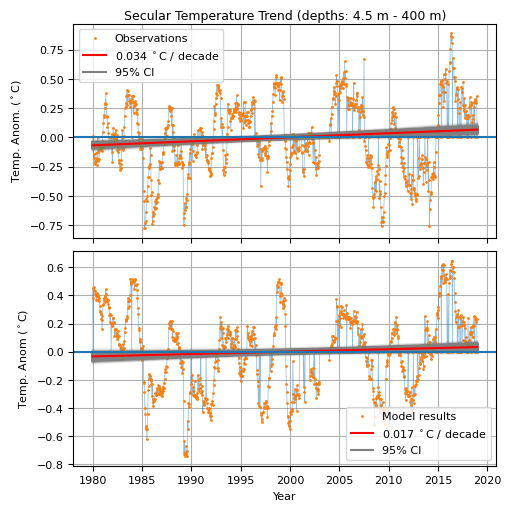

In [77]:
fact = 1

fig, axs = plt.subplots(2,1, figsize=(5*fact, 5*fact), facecolor='w', edgecolor='k', constrained_layout=True)
axs = axs.ravel()
# fig.tight_layout(pad=0.1)

# obs_gt4mtemp = obs_gt4mtemp.values # if

# top10mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
# axs[0].axhline(y=0)
tyr = np.arange(1980,2019,(1/24))
axs[0].plot(tyr,obs_gt4mtemp,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(obs_gt4mtemp)]
y = obs_gt4mtemp[~np.isnan(obs_gt4mtemp)]
# A = np.vstack([x, np.ones(len(x))]).T
# m, c = np.linalg.lstsq(A, y, rcond=None)[0] # old way
axs[0].plot(x, y, '.', label='Observations', markersize=2)
## compute the confidence intervals for the regressions #
# Number of bootstrap iterations
n_iterations = 1000

bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, obs_gt4mtemp, tyr)
confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
# Check if the original slope is within the confidence interval
is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
# Print the results
print(f"Original slope: {orig_slope:.4f}")
print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")
# Plot the linear regression lines from the bootstrap samples
for i in range(n_iterations):
    if i == 0:
        axs[0].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=1, label="95% CI")
    else:
        axs[0].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=0.02)


axs[0].plot(x, orig_slope*x + orig_bias, 'r', label=f'{round(orig_slope*10,3)} $^\circ$C / decade')


axs[1].plot(tyr,mod_gt4mtemp,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(mod_gt4mtemp)]
y = mod_gt4mtemp[~np.isnan(mod_gt4mtemp)]
axs[1].plot(x, y, '.', label='Model results', markersize=2)

# bootstrap analysis
bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, mod_gt4mtemp, tyr)
confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
# Check if the original slope is within the confidence interval
is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
# Print the results
print(f"Original slope: {orig_slope:.4f}")
print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")


# Plot the linear regression lines from the bootstrap samples
for i in range(n_iterations):
    if i == 0:
        # get label for legend
        axs[1].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=1, label="95% CI")
    else:
        axs[1].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=0.02)

axs[1].plot(x, orig_slope*x + orig_bias, 'r', label=f'{round(orig_slope*10,3)} $^\circ$C / decade')

# reorder legend
plt.sca(axs[0])
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
axs[0].axhline(y=0)
axs[0].grid()

# reorder legend
plt.sca(axs[1])
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
axs[1].axhline(y=0)
axs[1].grid()

axs[0].set_title('Secular Temperature Trend (depths: 4.5 m - 400 m)', fontsize=9, pad=3)
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelbottom=False)
axs[0].tick_params(axis='y', labelsize=8)
axs[1].tick_params(axis='x', labelbottom=True, labelsize=8)
axs[1].tick_params(axis='y', labelsize=8)
axs[1].set_xlabel('Year', fontsize=8)
axs[0].set_ylabel('Temp. Anom. ($^\circ$C)', fontsize=8)
axs[1].set_ylabel('Temp. Anom ($^\circ$C)', fontsize=8)


In [236]:
slope_obs_mk

0.003614671120039773

Original slope: 0.0078
95% Confidence Interval: 0.0052 to 0.0103
Is the trend significant at the 95% level? Yes
Original slope: 0.0057
95% Confidence Interval: 0.0034 to 0.0080
Is the trend significant at the 95% level? Yes


Text(0, 0.5, 'Temp. Anom ($^\\circ$C)')

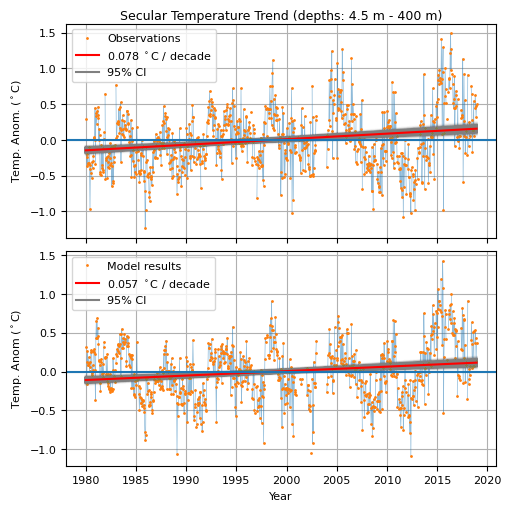

In [9]:
fact = 1

fig, axs = plt.subplots(2,1, figsize=(5*fact, 5*fact), facecolor='w', edgecolor='k', constrained_layout=True)
axs = axs.ravel()
# fig.tight_layout(pad=0.1)

# top10mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
# axs[0].axhline(y=0)
tyr = np.arange(1980,2019,(1/24))
axs[0].plot(tyr,obs_gt4mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(obs_gt4mtemp.values)]
y = obs_gt4mtemp.values[~np.isnan(obs_gt4mtemp.values)]
# A = np.vstack([x, np.ones(len(x))]).T
# m, c = np.linalg.lstsq(A, y, rcond=None)[0] # old way
axs[0].plot(x, y, '.', label='Observations', markersize=2)
## compute the confidence intervals for the regressions #
# Number of bootstrap iterations
n_iterations = 1000

bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, obs_gt4mtemp, tyr)
confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
# Check if the original slope is within the confidence interval
is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
# Print the results
print(f"Original slope: {orig_slope:.4f}")
print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")
# Plot the linear regression lines from the bootstrap samples
for i in range(n_iterations):
    if i == 0:
        axs[0].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=1, label="95% CI")
    else:
        axs[0].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=0.02)


axs[0].plot(x, orig_slope*x + orig_bias, 'r', label=f'{round(orig_slope*10,3)} $^\circ$C / decade')


axs[1].plot(tyr,mod_gt4mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(mod_gt4mtemp.values)]
y = mod_gt4mtemp.values[~np.isnan(mod_gt4mtemp.values)]
axs[1].plot(x, y, '.', label='Model results', markersize=2)

# bootstrap analysis
bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, mod_gt4mtemp, tyr)
confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
# Check if the original slope is within the confidence interval
is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
# Print the results
print(f"Original slope: {orig_slope:.4f}")
print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")


# Plot the linear regression lines from the bootstrap samples
for i in range(n_iterations):
    if i == 0:
        # get label for legend
        axs[1].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=1, label="95% CI")
    else:
        axs[1].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=0.02)

axs[1].plot(x, orig_slope*x + orig_bias, 'r', label=f'{round(orig_slope*10,3)} $^\circ$C / decade')

# reorder legend
plt.sca(axs[0])
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
axs[0].axhline(y=0)
axs[0].grid()

# reorder legend
plt.sca(axs[1])
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
axs[1].axhline(y=0)
axs[1].grid()

axs[0].set_title('Secular Temperature Trend (depths: 4.5 m - 400 m)', fontsize=9, pad=3)
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelbottom=False)
axs[0].tick_params(axis='y', labelsize=8)
axs[1].tick_params(axis='x', labelbottom=True, labelsize=8)
axs[1].tick_params(axis='y', labelsize=8)
axs[1].set_xlabel('Year', fontsize=8)
axs[0].set_ylabel('Temp. Anom. ($^\circ$C)', fontsize=8)
axs[1].set_ylabel('Temp. Anom ($^\circ$C)', fontsize=8)

In [125]:
values.shape

(850,)

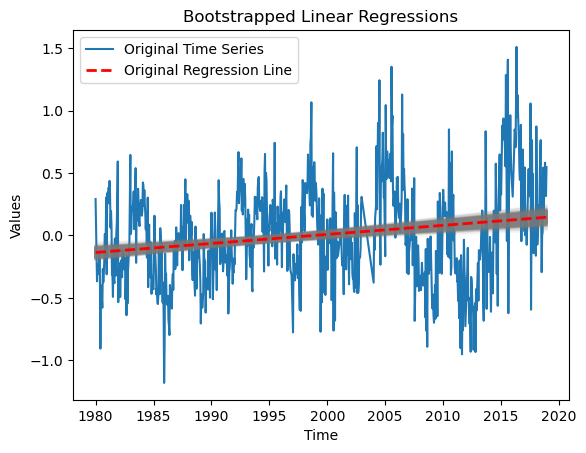

In [133]:
# Plot the original time series
plt.plot(time, values, label='Original Time Series')

# Plot the linear regression lines from the bootstrap samples
for i in range(n_iter):
    plt.plot(time, bootstrap_slopes[i] * time + bootstrap_biases[i], color='gray', alpha=0.05)

# Plot the line from the original regression
plt.plot(time, original_slope * time + original_bias, color='red', linestyle='--', linewidth=2, label='Original Regression Line')

# Add legend and labels
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Bootstrapped Linear Regressions')
plt.legend()

plt.show()

In [50]:
# import numpy as np
# import pandas as pd
# from sklearn.linear_model import LinearRegression

# # Generate sample time series data
# np.random.seed(0)
# time = np.arange(1, 101)
# values = 3 * time + np.random.normal(0, 10, size=100)

# # Fit linear regression to the original data
# regression = LinearRegression()
# regression.fit(time.reshape(-1, 1), values)

# # Function to compute the slope of the linear trend
# def compute_slope(x, y):
#     regression = LinearRegression()
#     regression.fit(x, y)
#     return regression.coef_[0]

# # Number of bootstrap iterations
# n_iterations = 1000

# # Initialize an array to store the slopes
# bootstrap_slopes = np.zeros(n_iterations)

# # Perform bootstrapping
# for i in range(n_iterations):
#     # Generate a bootstrap sample by resampling with replacement
#     indices = np.random.choice(len(values), len(values), replace=True)
#     bootstrap_sample = values[indices]
#     bootstrap_time = time[indices]

#     # Compute the slope of the linear trend on the bootstrap sample
#     bootstrap_slope = compute_slope(bootstrap_time.reshape(-1, 1), bootstrap_sample)
#     bootstrap_slopes[i] = bootstrap_slope

# # Compute the 95% confidence interval for the slopes
# confidence_interval = np.percentile(bootstrap_slopes, [2.5, 97.5])

# # Check if the original slope is within the confidence interval
# original_slope = regression.coef_[0]
# is_significant = (confidence_interval[0] <= original_slope <= confidence_interval[1])

# # Print the results
# print(f"Original slope: {original_slope:.2f}")
# print(f"95% Confidence Interval: {confidence_interval[0]:.2f} to {confidence_interval[1]:.2f}")
# print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")

Original slope: 2.97
95% Confidence Interval: 2.90 to 3.04
Is the trend significant at the 95% level? Yes


In [96]:
A

array([[1.98000000e+03, 1.00000000e+00],
       [1.98008333e+03, 1.00000000e+00],
       [1.98012500e+03, 1.00000000e+00],
       ...,
       [2.01883333e+03, 1.00000000e+00],
       [2.01887500e+03, 1.00000000e+00],
       [2.01891667e+03, 1.00000000e+00]])